## Importing Libraries, Dataset and Styling

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [ ]:
path = "/content/Revenue Breakups - 2024-04-25T160103.210.xlsx"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_excel(path)

/usr/local/lib/python3.10/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [ ]:
df.shape

(8685, 43)

In [ ]:
df['Count'] = 1
df['Count'].iloc[5450]

1

In [ ]:
#df = pd.read_excel(path)
df = df.set_index('Payment Date')
df.index = pd.to_datetime(df.index)

In [ ]:
df['Daily Sales'] = df.groupby('Payment Date')['Count'].sum()
df =  df[['Daily Sales']]
df

,Daily Sales
Payment Date,
2024-04-25,4
2024-04-22,16
2024-04-25,4
2024-04-25,4
2024-04-24,16
...,...
2021-12-31,4
2021-12-13,2
2021-11-29,1


In [ ]:
df.shape

(8685, 1)

In [ ]:
df.head()

,Daily Sales
Payment Date,
2024-04-25,4
2024-04-22,16
2024-04-25,4
2024-04-25,4
2024-04-24,16


### Data Stationary

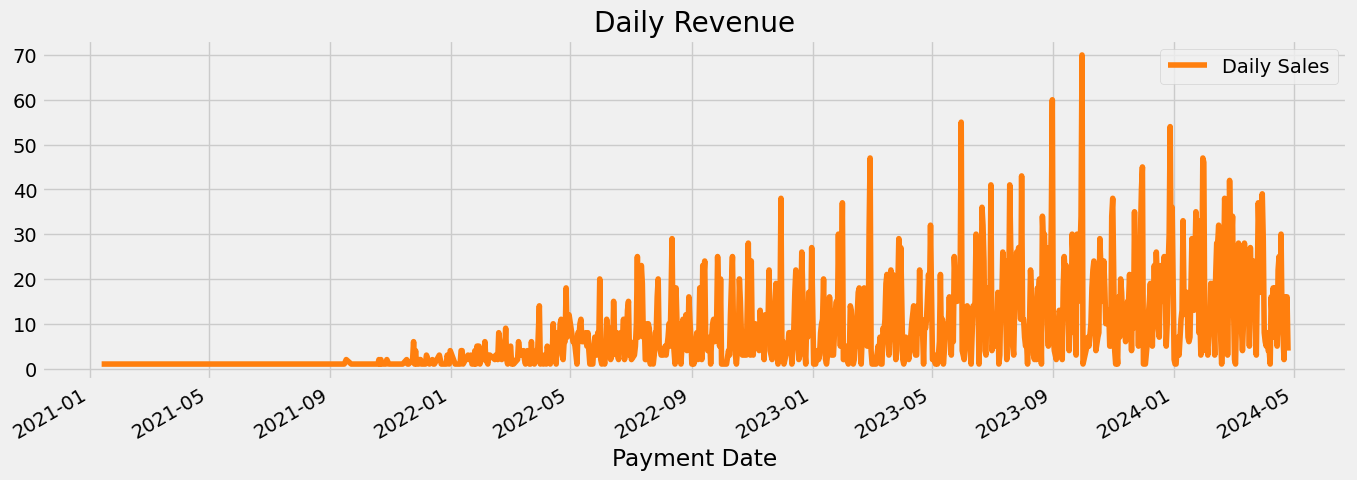

In [ ]:
df.plot(style = '-',figsize = (15,5),
        color = color_pal[1],
        title = "Daily Revenue")
plt.show()d

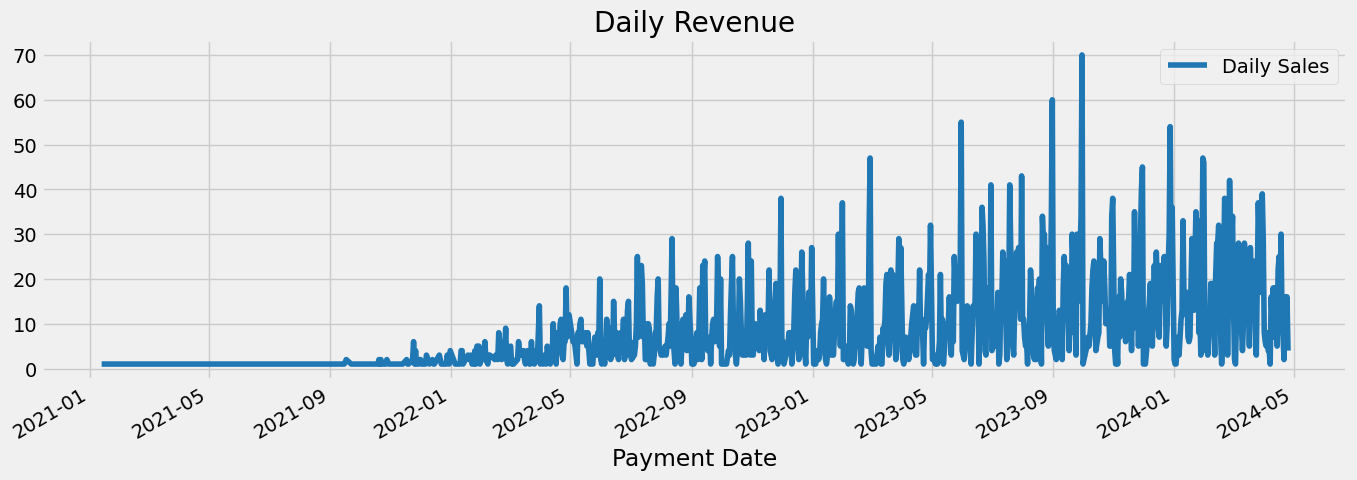

In [ ]:
df.plot(style='-', figsize = (15,5),
        color =  color_pal[0],
        title = 'Daily Revenue')
plt.show()

## Outlier Removal

<Axes: ylabel='Frequency'>

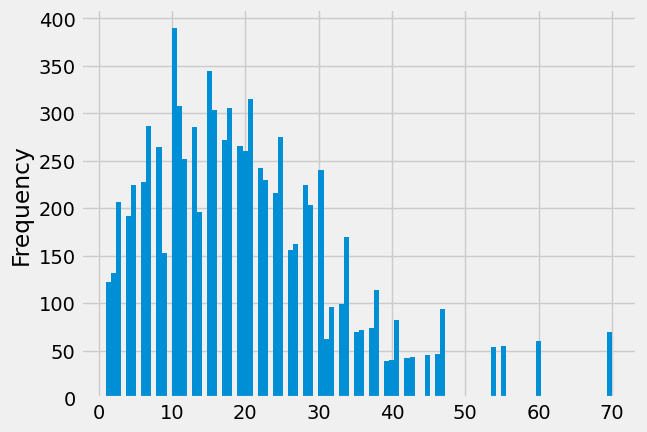

In [ ]:
df['Daily Sales'].plot(kind='hist', bins=100)

In [ ]:
from scipy.stats import zscore
z_scores = zscore(df['Daily Sales'])

threshold = 3

outlier_indices = np.where(np.abs(z_scores > 3))
df = df.drop(index = df.index[outlier_indices])
df.head()

,Daily Sales
Payment Date,
2024-04-25,4
2024-04-22,16
2024-04-25,4
2024-04-25,4
2024-04-24,16


## EDA

## Train Test Split

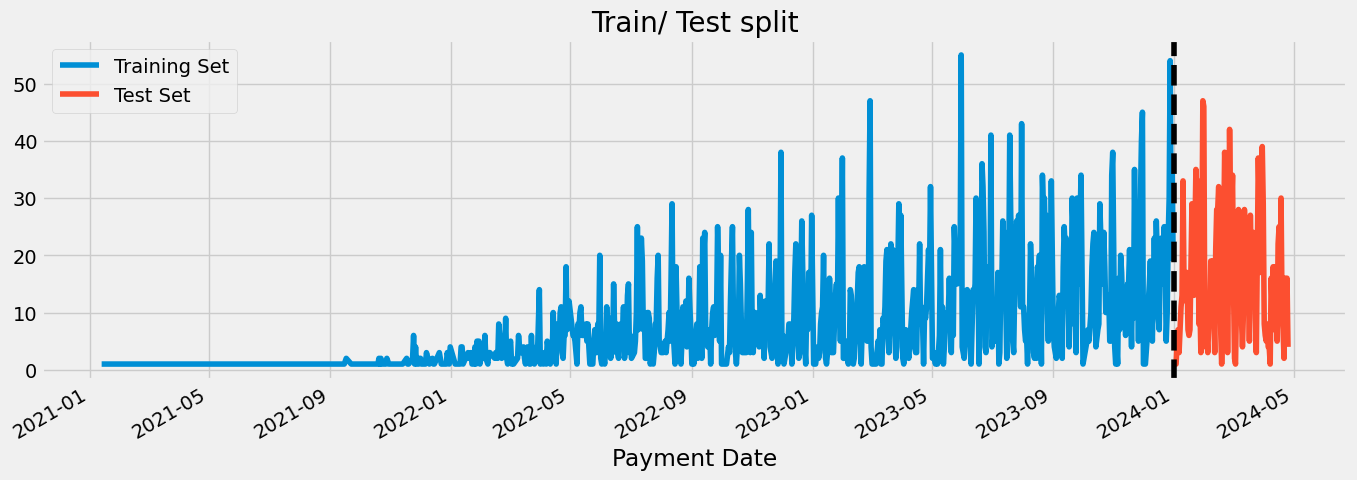

In [ ]:
train = df.loc[df.index < '01-01-2024']
test = df.loc[df.index > '01-01-2024']

fig , ax = plt.subplots(figsize =(15,5))
train.plot(ax=ax, label='Training Set', title = 'Train/ Test split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2024', ls='--', color='black')
ax.legend(['Training Set', 'Test Set'])
plt.show()

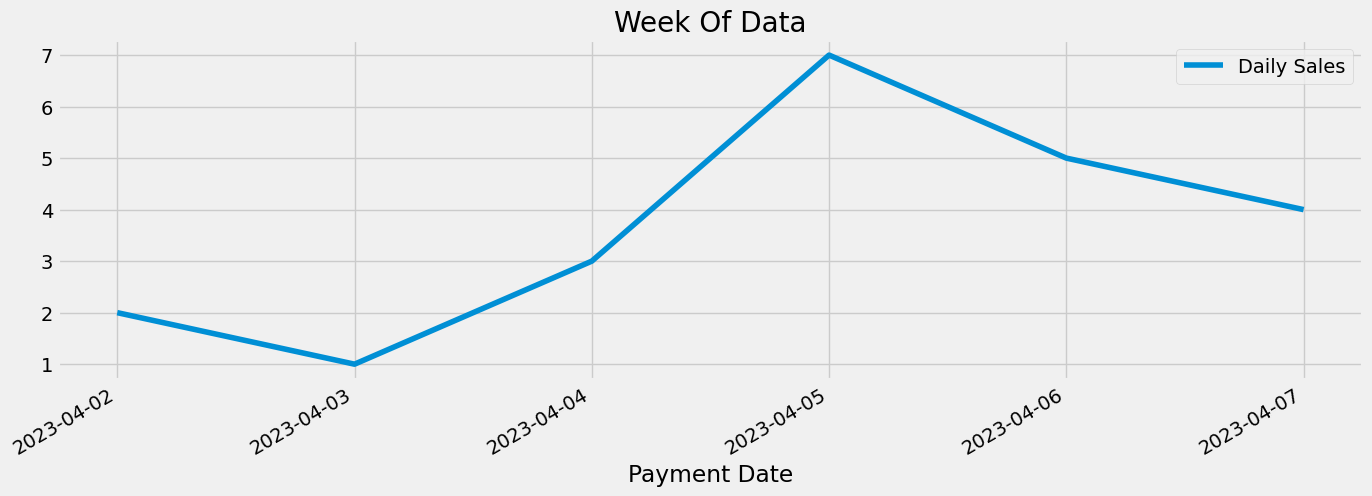

In [ ]:
df.loc[(df.index > '04-01-2023') & (df.index < '04-08-2023')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

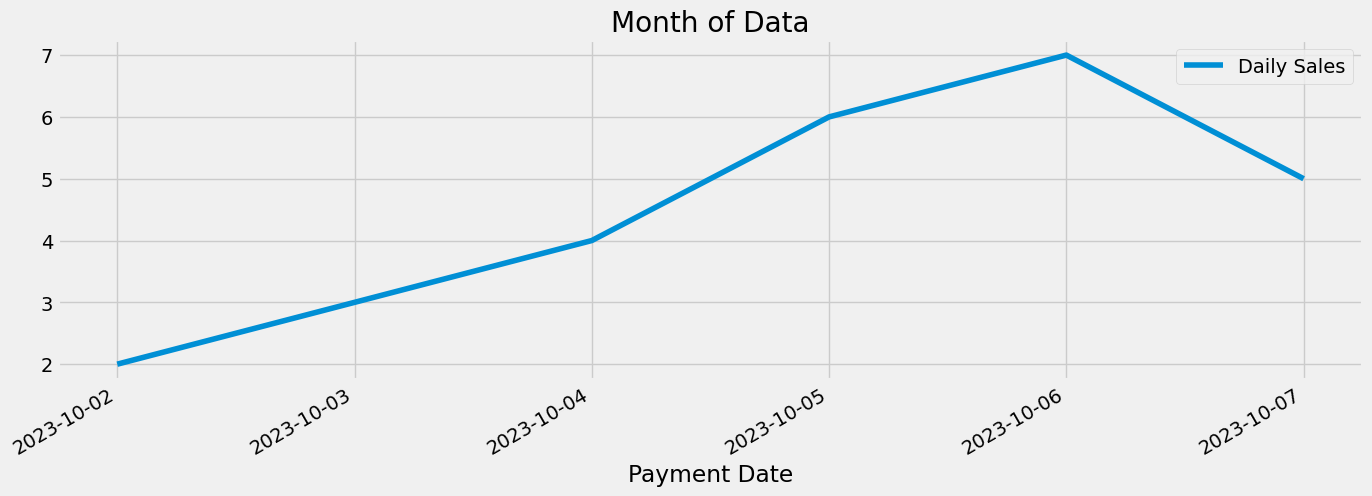

In [ ]:
df.loc[(df.index > '10-01-2023' ) & (df.index < '10-08-2023')].plot(figsize=(15,5), title='Month of Data')
plt.show()

# Time Series Split

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=30, gap=1)
df = df.sort_index()

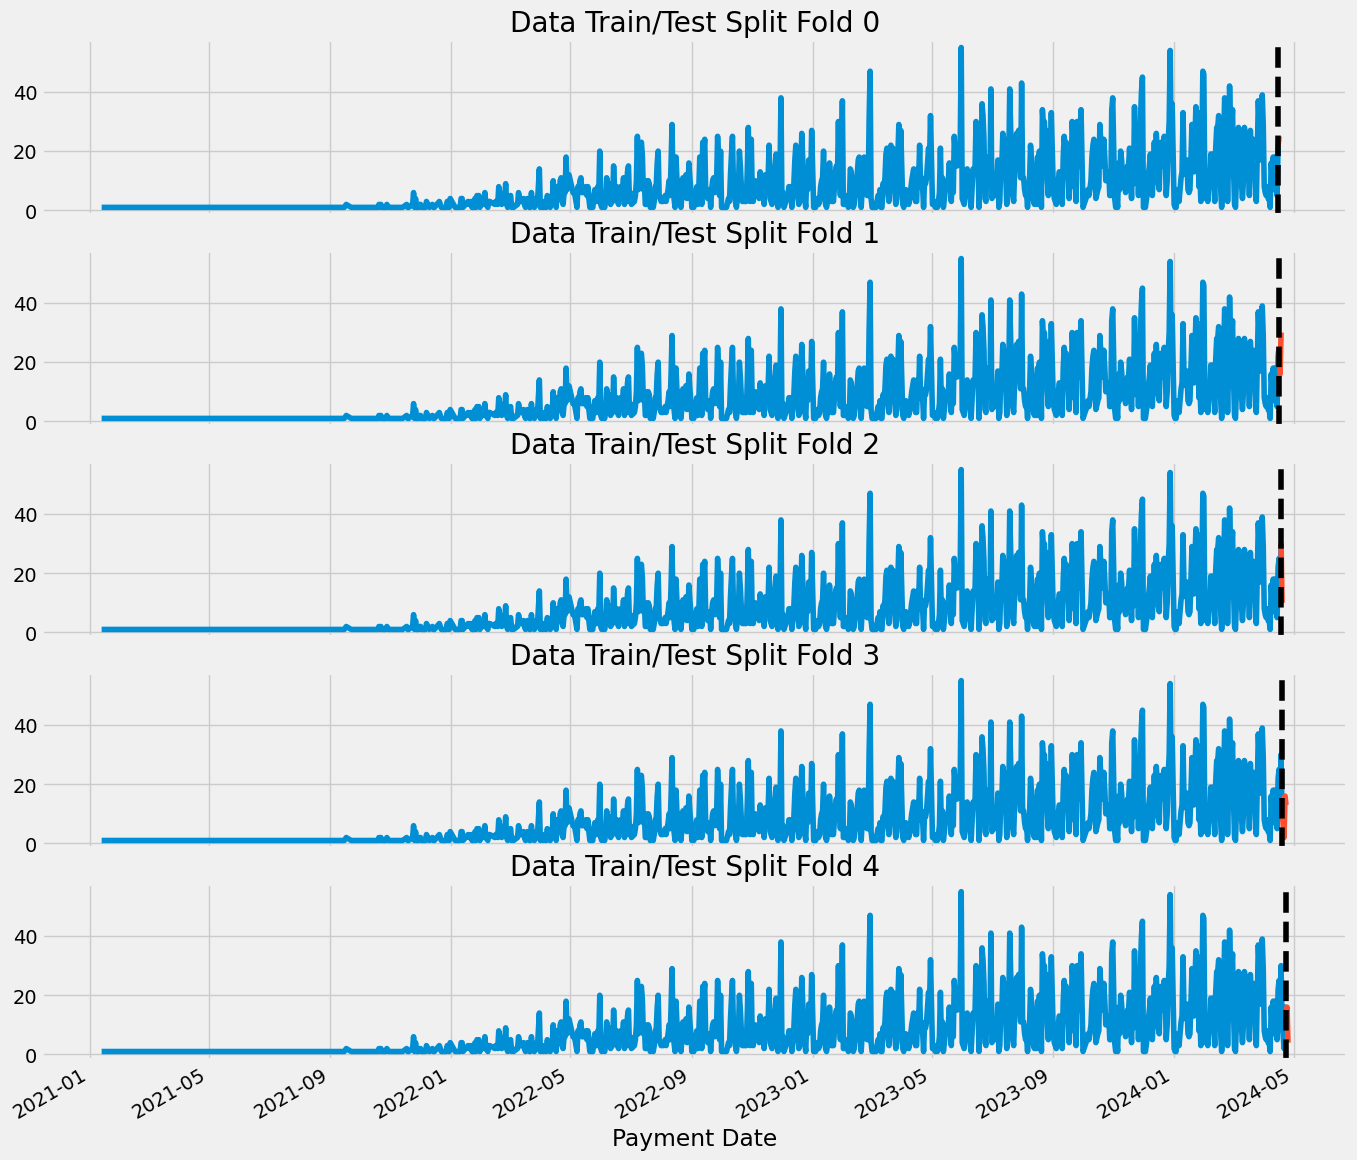

In [ ]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['Daily Sales'].plot(ax=axs[fold],
                              label='Training Set',
                              title=f'Data Train/Test Split Fold {fold}')
    test['Daily Sales'].plot(ax=axs[fold],
                             label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
    if fold == 5:  # Break the loop after 5 splits
        break
plt.show()


## Feature Creation

In [ ]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    #df['weekofmonth'] = df.index.weekofmonth
    return df

df = create_features(df)

## Lag Creation

In [ ]:
def add_lags(df):
    target_map = df['Daily Sales'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('30 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('60 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('90 days')).map(target_map)
    return df


In [ ]:
df = add_lags(df)
df.sample(4)

,Daily Sales,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3
Payment Date,,,,,,,,,,,,
2023-09-21,25,0,3,3,9,2023,264,21,38,28.0,3.0,24.0
2024-03-27,29,0,2,1,3,2024,87,27,13,42.0,12.0,54.0
2023-10-22,24,0,6,4,10,2023,295,22,42,24.0,30.0,14.0
2023-10-30,34,0,0,4,10,2023,303,30,44,NaN,NaN,11.0


In [ ]:
df.shape

(8555, 12)

In [ ]:
df.isnull().sum()

Daily Sales      0
hour             0
dayofweek        0
quarter          0
month            0
year             0
dayofyear        0
dayofmonth       0
weekofyear       0
lag1           555
lag2           737
lag3           641
dtype: int64

# EDA

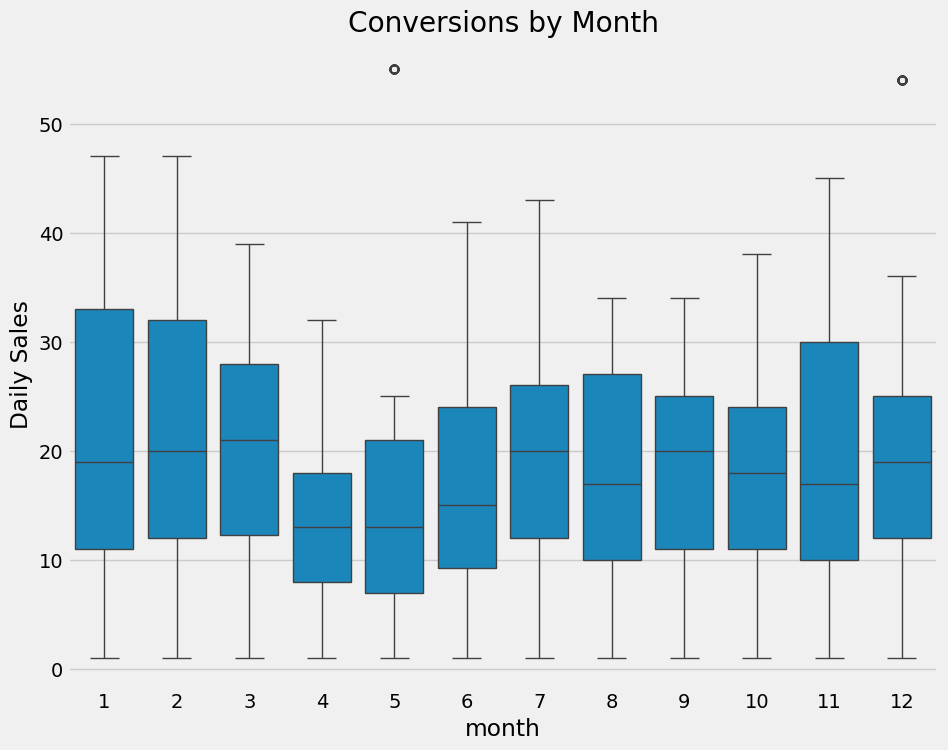

In [ ]:
fig,ax= plt.subplots(figsize=(10,8))
sns.boxplot(data = df, x='month',y='Daily Sales')
ax.set_title('Conversions by Month')

plt.show()

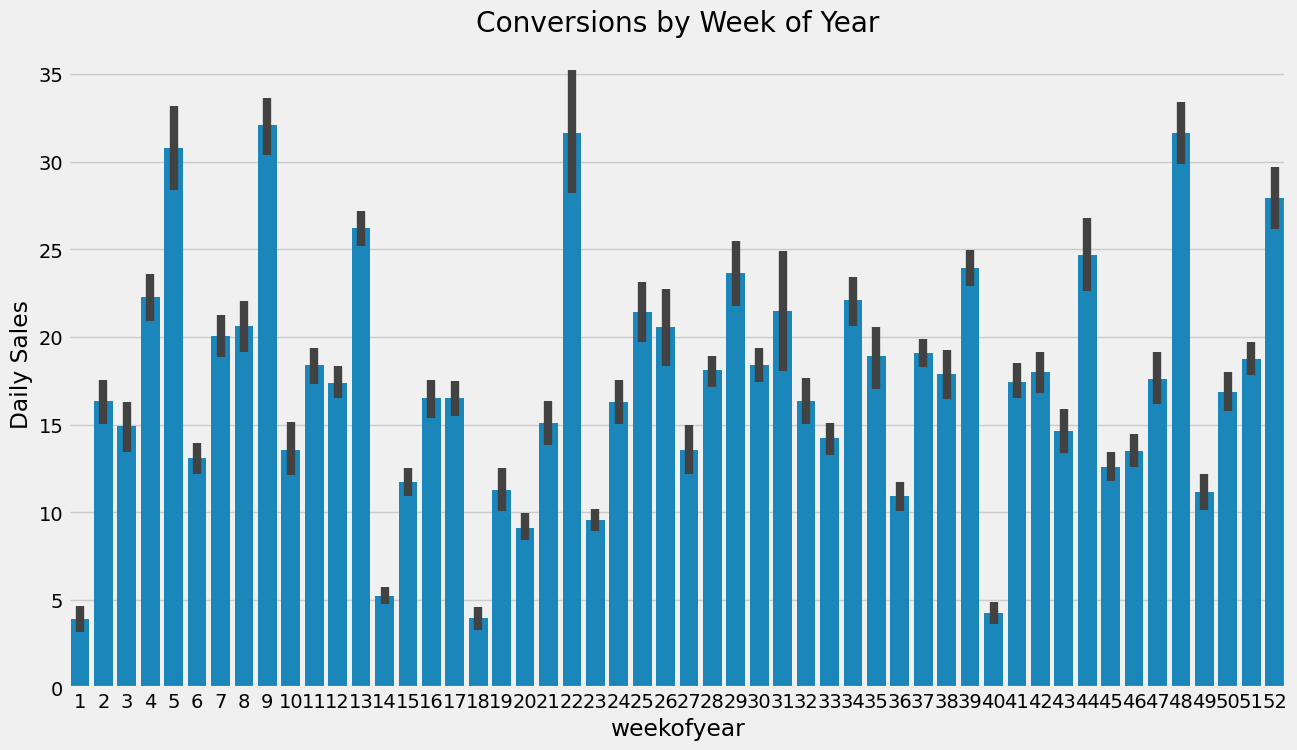

In [ ]:
fig,ax= plt.subplots(figsize=(14,8))
sns.barplot(data = df, x='weekofyear',y='Daily Sales')
ax.set_title('Conversions by Week of Year')

plt.show()

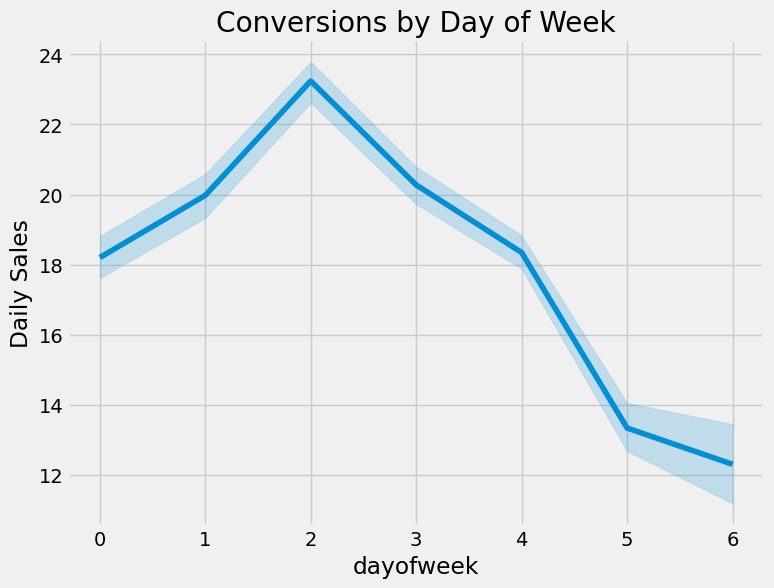

In [ ]:
fig,ax= plt.subplots(figsize=(8,6))
sns.lineplot(data = df, x='dayofweek',y='Daily Sales')
ax.set_title('Conversions by Day of Week')
plt.show()

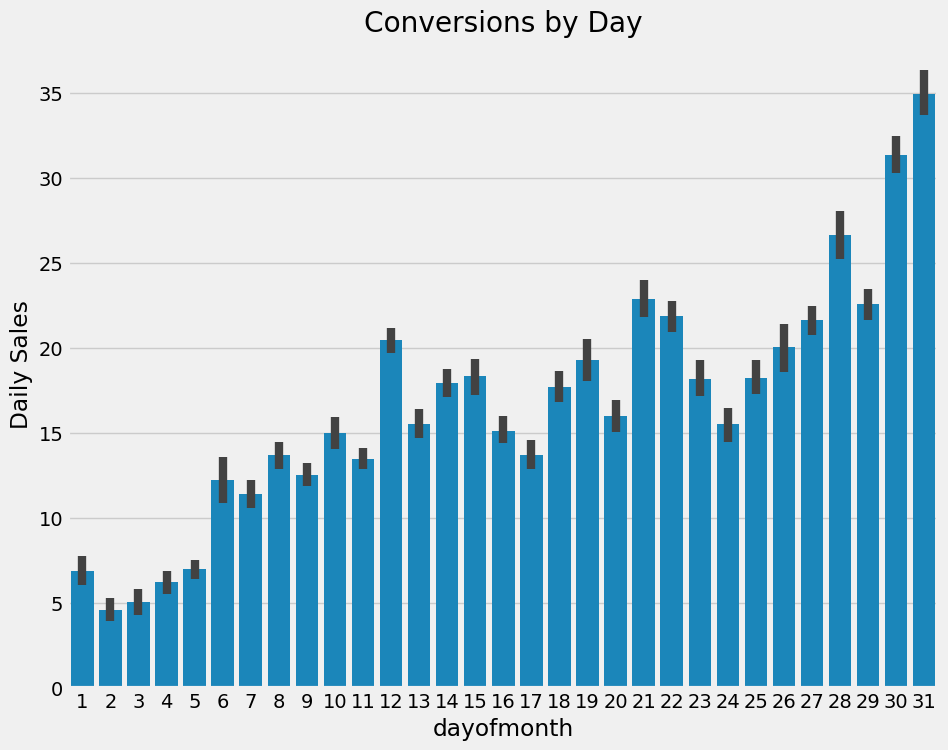

In [ ]:
fig,ax= plt.subplots(figsize=(10,8))
sns.barplot(data=df, x='dayofmonth',y='Daily Sales')
ax.set_title('Conversions by Day')
plt.show()

## Training Using Cross Validation

In [ ]:
df.dropna()
df.shape

(8555, 12)

In [ ]:
tss = TimeSeriesSplit(n_splits=5, test_size=30, gap=1)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'Daily Sales'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                           n_estimators=400,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:21.83569	validation_1-rmse:23.23486
[100]	validation_0-rmse:11.59530	validation_1-rmse:10.44297


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [11:04:57] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:8.72494	validation_1-rmse:6.27517
[300]	validation_0-rmse:7.78517	validation_1-rmse:5.57767
[399]	validation_0-rmse:7.40281	validation_1-rmse:5.07969
[0]	validation_0-rmse:21.84038	validation_1-rmse:21.71283
[100]	validation_0-rmse:11.59041	validation_1-rmse:9.77878


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [11:04:58] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:8.71884	validation_1-rmse:7.23891
[300]	validation_0-rmse:7.79537	validation_1-rmse:6.91974
[355]	validation_0-rmse:7.55320	validation_1-rmse:7.20600
[0]	validation_0-rmse:21.83921	validation_1-rmse:25.53683
[100]	validation_0-rmse:11.59551	validation_1-rmse:13.73106


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [11:04:58] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:8.72896	validation_1-rmse:9.52554
[300]	validation_0-rmse:7.80931	validation_1-rmse:7.59511
[399]	validation_0-rmse:7.42912	validation_1-rmse:7.17148
[0]	validation_0-rmse:21.85532	validation_1-rmse:12.45591
[100]	validation_0-rmse:11.59697	validation_1-rmse:3.33602
[127]	validation_0-rmse:10.43727	validation_1-rmse:4.67185


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [11:04:59] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:21.82936	validation_1-rmse:13.28345
[100]	validation_0-rmse:11.59003	validation_1-rmse:4.71716
[123]	validation_0-rmse:10.58643	validation_1-rmse:5.85483


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [11:04:59] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


In [ ]:
df['Daily Sales'].mean()

19.262536528345997

In [ ]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 5.1591
Fold scores:[5.076752384392505, 6.886889091593307, 7.1714836340584505, 2.718226291252315, 3.9422258019222802]


# Future Prediction

In [ ]:
# Retrain on all data
df = create_features(df)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2','lag3']
TARGET = 'Daily Sales'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',
                       n_estimators=400,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[0]	validation_0-rmse:21.80467
[100]	validation_0-rmse:11.59679


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [11:05:41] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:8.79532
[300]	validation_0-rmse:7.89602
[399]	validation_0-rmse:7.46109


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=400, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

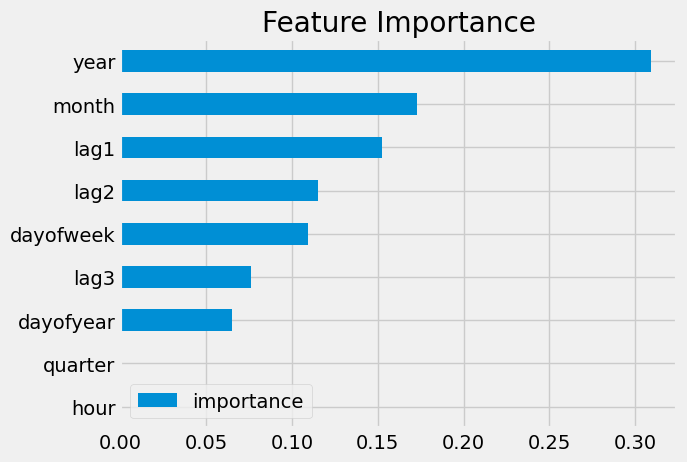

In [ ]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [ ]:
df.index.max()

Timestamp('2024-04-25 00:00:00')

## Future Prediction

In [ ]:
# Create future dataframe
future = pd.date_range('2024-04-25','2024-04-30', freq='D')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [ ]:
df_and_future.shape

(8561, 13)

In [ ]:
future_w_features = df_and_future.query('isFuture').copy()

In [ ]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

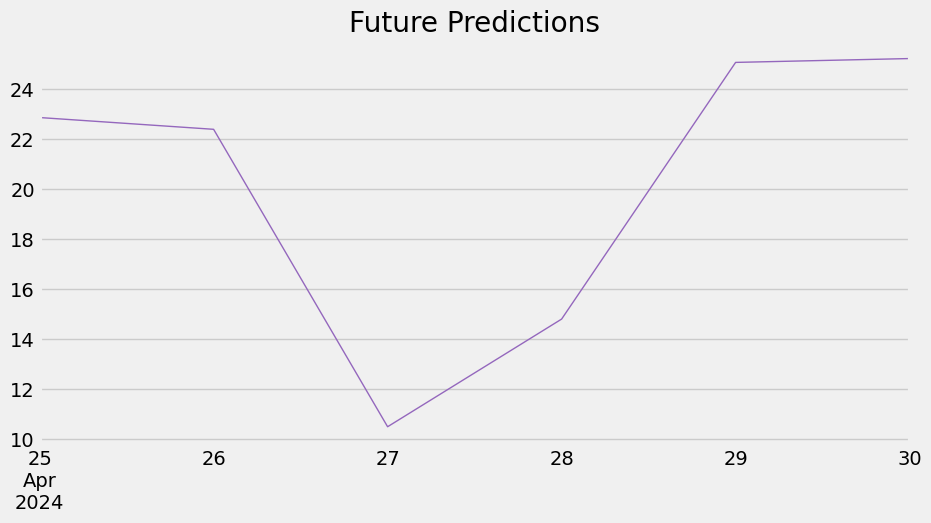

In [ ]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

In [ ]:
future_w_features.pred.sum()

120.87549

In [ ]:
future_w_features= future_w_features[['pred']]
future_w_features.reset_index(inplace=True)

In [ ]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 5.1591
Fold scores:[5.076752384392505, 6.886889091593307, 7.1714836340584505, 2.718226291252315, 3.9422258019222802]


In [ ]:
future_w_features.to_excel('XGB_prediction.xlsx',index=False)

In [ ]:
total_revenue = future_w_features.pred.sum().round()
print('Total Predicted Count for this month',total_revenue)

Total Predicted Count for this month 121.0


In [ ]:
count_with_lowest = round(total_revenue/75800)

count_with_base_price  = round(total_revenue/78800)

count_with_mean_price = round(total_revenue/78945)

print(f'Count with lowest sale price of 70800 : {count_with_lowest}')
print(f'Count with base sale price of 78000 : {count_with_base_price}')
print(f'Count with average sale price of 78945 : {count_with_mean_price}')

Count with lowest sale price of 70800 : 502
Count with base sale price of 78000 : 482
Count with average sale price of 78945 : 482


In [ ]:
df = pd.read_excel(path)

In [ ]:
df['Co-Ordinator'] = df['Co-Ordinator'].str.strip()
df = df[df['Co-Ordinator'].isin(['Amirtharaj M','Benita Jeglin','Benita Jeglin',
                                'Lakshmi  Devarajan','Manish Kumar','Manoj  Prabhu','N Saifudeen',
                                'Nandhini Arumugam','Neha varshney','Nisha MV','Tirtha Doshi'])]
df['Co-Ordinator'].value_counts()

Lakshmi  Devarajan    798
Benita Jeglin         734
Manoj  Prabhu         623
Tirtha Doshi          588
Neha varshney         588
N Saifudeen           501
Nisha MV              497
Manish Kumar          496
Amirtharaj M          487
Nandhini Arumugam     476
Name: Co-Ordinator, dtype: int64

In [ ]:
df = pd.read_excel(path)
df = df.set_index('Date of Enrolment')
df.index = pd.to_datetime(df.index)

In [ ]:
df['Daily Sales'] = df.groupby('Date of Enrolment')['Course Value'].sum()
df['Daily Sales']

Date of Enrolment
2023-07-30     315200.0
2023-07-30     315200.0
2023-07-30     315200.0
2023-07-30     315200.0
2023-07-29    1079200.0
                ...    
2022-04-13    1050000.0
2022-04-13    1050000.0
2022-04-11     985700.0
2022-12-04     150600.0
2023-07-08    1099200.0
Name: Daily Sales, Length: 8000, dtype: float64

In [ ]:
grouped_df = df.groupby(['Date of Enrolment','Product','Co-Ordinator'])[['Course Value']].sum()
grouped_df

Course Value
Date of Enrolment Product              Co-Ordinator                         
2022-04-01        Zen_Data_Engineering    Bhuvaneshwari R            70800.0
                                          Lakshmi  Devarajan         70800.0
                  Zen_Data_Science        Bhuvaneshwari R            65800.0
                                          Gopika  Chandran          202400.0
                                          Lakshmi  Devarajan        131290.0
...                                                                      ...
2023-07-29        Zen_ML_Engineer         Sreeja M                   78800.0
2023-07-30        Zen_Data_Science        Manish Kumar               78800.0
                                          Manoj  Prabhu              78800.0
                                          Nandhini Arumugam          78800.0
                                          Tirtha Doshi               78800.0

[3959 rows x 1 columns]

In [ ]:
g

In [ ]:
# Extract relevant features from the datetime column
df['Year'] = df['Date of Enrolment'].dt.year
df['Month'] = df['Date of Enrolment'].dt.month
df['Day'] = df['Date of Enrolment'].dt.day


In [ ]:
unique_products =  df['Product'].unique()
unique_coordinators = df['Co-Ordinator'].unique()
unique_coordinators

array(['Tirtha Doshi', 'Manish Kumar', 'Manoj  Prabhu',
       'Nandhini Arumugam', 'Nisha MV', 'N Saifudeen', 'Amirtharaj M',
       'Benita Jeglin', 'Lakshmi  Devarajan', 'Neha varshney'],
      dtype=object)

In [ ]:
dataframes = {}

for product in unique_products:
    for co_ordinator in unique_coordinators:
        df_product_coordinator = df[(df['Product'] == product) & ( df['Co-Ordinator'] == co_ordinator)]

        key = f"{product}_{co_ordinator}"
        dataframes[key] = df_product_coordinator

In [ ]:
dataframes.keys()

dict_keys(['Zen_Data_Science_Tirtha Doshi', 'Zen_Data_Science_Manish Kumar', 'Zen_Data_Science_Manoj  Prabhu', 'Zen_Data_Science_Nandhini Arumugam', 'Zen_Data_Science_Nisha MV', 'Zen_Data_Science_N Saifudeen', 'Zen_Data_Science_Amirtharaj M', 'Zen_Data_Science_Benita Jeglin', 'Zen_Data_Science_Lakshmi  Devarajan', 'Zen_Data_Science_Neha varshney', 'IITM_Pravartak_Autodesk_Certified_Computer_Aided_Civil_Technology_Tirtha Doshi', 'IITM_Pravartak_Autodesk_Certified_Computer_Aided_Civil_Technology_Manish Kumar', 'IITM_Pravartak_Autodesk_Certified_Computer_Aided_Civil_Technology_Manoj  Prabhu', 'IITM_Pravartak_Autodesk_Certified_Computer_Aided_Civil_Technology_Nandhini Arumugam', 'IITM_Pravartak_Autodesk_Certified_Computer_Aided_Civil_Technology_Nisha MV', 'IITM_Pravartak_Autodesk_Certified_Computer_Aided_Civil_Technology_N Saifudeen', 'IITM_Pravartak_Autodesk_Certified_Computer_Aided_Civil_Technology_Amirtharaj M', 'IITM_Pravartak_Autodesk_Certified_Computer_Aided_Civil_Technology_Benita J

In [ ]:
dataframes['Zen_Business_Analytics_Digital_Marketing_Amirtharaj M'].shape

(25, 86)

In [ ]:
# Assuming you have the list of unique products and coordinators
unique_products = ['productA', 'productB', 'productC', 'productD', 'productE', 'productF']
unique_coordinators = ['coordinator1', 'coordinator2', 'coordinator3', 'coordinator4', 'coordinator5', 'coordinator6', 'coordinator7', 'coordinator8', 'coordinator9', 'coordinator10']

# Create a dictionary to store the DataFrames for each combination
dataframes = {}

# Loop over each product
for product in unique_products:
    # Loop over each coordinator
    for co_ordinator in unique_coordinators:
        # Filter the DataFrame based on the current product and coordinator
        df_product_coordinator = df[(df['Product'] == product) & (df['Co-Ordinator'] == co_ordinator)]

        # Store the filtered DataFrame in the dictionary with a unique key
        key = f"{product}_{co_ordinator}"
        dataframes[key] = df_product_coordinator

# Now you have separate DataFrames for each combination, stored in the 'dataframes' dictionary.
# You can access each DataFrame using its key, for example:
df1 = dataframes['productA_coordinator1']
df2 = dataframes['productB_coordinator1']
df3 = dataframes['productC_coordinator1']
# ... and so on for other combinations.


In [ ]:
# Step 1: Preprocess Data
df['unique_id'] = df['Date of Enrolment'].astype(str) + '_' + df['Product'] + '_' + df['Co-Ordinator']
df.head(2)

,Student Full Name,Date of Enrolment,Preferred Date to Join,Sales PBC Selected Date,Bootcamp Coordinator Status,HR_Interview Status,Pre bootcamp attended?,Bootcamp Coordinator,Stage,Added Time,...,GUVI PRO ACCESS,Invoice Created,Invoice Created Date,Invoice Status Check,ZB Invoice ID,Daily Sales,Year,Month,Day,unique_id
0,Poonam Konnuri,2023-07-30,2023-08-02,2023-08-02,Not initiated,NaN,No,Krishna kumari,Preboot Attending,2023-07-30 15:25:13,...,Yes,No,NaT,NaN,NaN,NaN,2023,7,30,2023-07-30_Zen_Data_Science_Tirtha Doshi
1,Anvitha,2023-07-30,2023-08-05,2023-08-05,Not initiated,NaN,No,Krishna kumari,Preboot Attending,2023-07-30 14:43:44,...,Yes,No,NaT,NaN,NaN,NaN,2023,7,30,2023-07-30_Zen_Data_Science_Manish Kumar


In [ ]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split

# Assuming you have a DataFrame named 'df' containing the sales data with columns 'date', 'product', 'coordinator', and 'sales'

# Step 1: Preprocess Data
df['unique_id'] = df['Date of Enrolment'].astype(str) + '_' + df['Product'] + '_' + df['Co-Ordinator']

# Step 2: Split Data by Product and Coordinator
unique_products = df['product'].unique()
unique_coordinators = df['coordinator'].unique()

for product in unique_products:
    for coordinator in unique_coordinators:
        df_product_coordinator = df[(df['product'] == product) & (df['coordinator'] == coordinator)]
        # If you have sufficient data for this product and coordinator combination, proceed with training the model
        if len(df_product_coordinator) > min_required_data_points:
            X = df_product_coordinator[['date']]  # Input features (date in this case)
            y = df_product_coordinator['sales']   # Target variable (sales)

            # Step 3: Train the model
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            model = xgb.XGBRegressor()
            model.fit(X_train, y_train)

            # Step 4: Make Predictions
            predictions = model.predict(X_test)

            # Perform any evaluation or post-processing as required for each product and coordinator combination
            # (e.g., calculate accuracy, MAPE, etc.)


In [ ]:
from sklearn.model_selection import train_test_split
import xgboost as xgb

In [ ]:
df_product_coordinator

,Student Full Name,Preferred Date to Join,Sales PBC Selected Date,Bootcamp Coordinator Status,HR_Interview Status,Pre bootcamp attended?,Bootcamp Coordinator,Stage,Added Time,Co-Ordinator,...,Web development course activated?,Web development course activated date,FormState,Sale Activity Added in LSQ,GUVI PRO ACCESS,Invoice Created,Invoice Created Date,Invoice Status Check,ZB Invoice ID,Daily Sales
Date of Enrolment,,,,,,,,,,,,,,,,,,,,,


In [ ]:
import numpy as np
import statsmodels.api as sm

# Sample data
X = np.random.rand(100, 2)  # Independent variables
y = np.random.rand(100)     # Dependent variable

# Add constant term for intercept
X = sm.add_constant(X)

# Fit OLS model
model = sm.OLS(y, X)
results = model.fit()

# Print summary of results
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                 -0.015
Method:                 Least Squares   F-statistic:                    0.2610
Date:                Thu, 25 Apr 2024   Prob (F-statistic):              0.771
Time:                        13:14:33   Log-Likelihood:                -17.451
No. Observations:                 100   AIC:                             40.90
Df Residuals:                      97   BIC:                             48.72
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5224      0.072      7.288      0.0